In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Variable Hyperparameters
num_qubits_list = [4, 8]
r_list = [0.0, 0.5, 1.0]
var_ansatz_list = ["QCNN_not_shared", "QCNN_shared", "SEL"]
var_anstaz_label_list = ["QCNN\n (not shared)", "QCNN\n(shared)", "SEL"]
num_layers_list = [1, 3, 5, 7, 9]
num_classes = 4
max_steps = 5000
learning_rate = 0.001
convergence_interval = 300

# Load data for a specific experiment path
def load_data(PATH):
    return (
        np.load(PATH + 'generalization_gap.npy'),
        np.load(PATH + 'test_acc.npy'),
        np.load(PATH + 'mu_marg_Q1.npy'),
        np.load(PATH + 'mu_marg_Q2.npy'),
        np.load(PATH + 'mu_marg_mean.npy'),
        np.load(PATH + 'mu_param.npy'),
        np.load(PATH + 'mu_param_eff10.npy'),
        np.load(PATH + 'mu_param_eff100.npy')
    )

# Fetch data for a single experiment
def get_data_(num_qubits, r, var_ansatz, num_layers, exp_index):
    PATH = f'../../results_TFIM/2C/{r}R/8Q/{var_ansatz}/{num_layers}L_5000MS_Full BatchBS_0.001LR_300conv/20S/{exp_index}E/'
    #PATH = f'/Users/tak/Q-margin/QPR/results_300conv/4C/{r}R/{num_qubits}Q/{var_ansatz}/{num_layers}L_5000MS_Full BatchBS_0.001LR_300conv/20S/{exp_index}E/'
    #PATH = f'../../results_300conv/{num_classes}C/{r}R/{num_qubits}Q/{var_ansatz}/{num_layers}L_{max_steps}MS_FullBatchBS_{learning_rate}LR_{convergence_interval}conv/20S/{exp_index}E/'
    data = load_data(PATH)
    return np.array(data)  # Return raw data for the single experiment

# Apply transformations to data (e.g., reciprocal, square root)
def reciprocal_transform(x):
    return 1 / x

def apply_transformation(data, transforms):
    transformed_data = []
    for datum, transform in zip(data, transforms):
        transformed_data.append(transform(datum))
    return transformed_data

# Get data for a single experiment across different x_axis parameters
def get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_index):
    g_list = []
    test_acc_list = []
    mu_marg_Q1_list = []
    mu_marg_Q2_list = []
    mu_marg_mean_list = []
    mu_param_list = []
    mu_param_eff10_list = []
    mu_param_eff100_list = []

    data_lists = [
        g_list, test_acc_list, mu_marg_Q1_list, mu_marg_Q2_list,
        mu_marg_mean_list, mu_param_list, mu_param_eff10_list, mu_param_eff100_list
    ]
    
    transforms = [
        lambda x: x, lambda x: x, reciprocal_transform, reciprocal_transform,
        reciprocal_transform, np.sqrt, np.sqrt, np.sqrt
    ]

    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    
    # Loop through the x_axis parameter values and collect data
    for param_value in param_map[x_axis]:
        if x_axis == "num_layers":
            num_layers = param_value
        elif x_axis == "r":
            r = param_value
        elif x_axis == "var_ansatz":
            var_ansatz = param_value

        # Fetch data for a single experiment
        data = get_data_(num_qubits, r, var_ansatz, num_layers, exp_index)

        # Apply transformations and append the data
        transformed_data = apply_transformation(data, transforms)
        for lst, datum in zip(data_lists, transformed_data):
            lst.append(datum)

    # Convert lists to numpy arrays
    g_array = np.array(g_list)
    test_acc_array = np.array(test_acc_list)
    mu_marg_Q1_array = np.array(mu_marg_Q1_list)
    mu_marg_Q2_array = np.array(mu_marg_Q2_list)
    mu_marg_mean_array = np.array(mu_marg_mean_list)
    mu_param_array = np.array(mu_param_list)
    mu_param_eff10_array = np.array(mu_param_eff10_list)
    mu_param_eff100_array = np.array(mu_param_eff100_list)

    return np.array([g_array, test_acc_array, mu_marg_Q1_array, mu_marg_Q2_array, 
                     mu_marg_mean_array, mu_param_array, mu_param_eff10_array, 
                     mu_param_eff100_array])

# Plot the results for a single experiment
def getplots_single(x_axis, y_axis1, y_axis2, y_axis3, num_qubits, var_ansatz, r, num_layers, exp_index=0):
    # Mapping for x-axis labels
    x_axis_label_map = {
        "num_layers": "Number of Layers",
        "r": "Percentage of Randomized Labels",
        "var_ansatz": "Variational Ansatz"
    }
    
    # Mapping for x-ticks
    x_ticks_map = {
        "QCNN_not_shared": "QCNN",
        "QCNN_shared": "QCNN (param shared)"
    }

    fig, ax_left = plt.subplots(figsize=(7, 6))
    plt.rcParams.update({'font.size': 14}) 

    # Create the first y-axis on the right
    ax_right1 = ax_left.twinx()

    # Create the second y-axis on the right
    ax_right2 = ax_left.twinx()
    ax_right2.spines['right'].set_position(('outward', 70))  # Offset the second y-axis

    # Get data for the single experiment
    data = get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_index)

    # Define x-axis parameter values
    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    x_data = param_map[x_axis]

    # Map x-ticks if necessary
    x_data = [x_ticks_map.get(label, label) for label in x_data]

    # Extract the relevant data for the single experiment
    y1_list = data[data_mapping[y_axis1]]
    y2_list = data[data_mapping[y_axis2]]
    y3_list = data[data_mapping[y_axis3]]

    # Plotting on the left y-axis with solid line
    line1, = ax_left.plot(x_data, y1_list, label=y_axis1, marker='x', markersize=7, color='purple', linestyle='-')
    ax_left.set_ylabel(y_axis1, color='purple')

    # Plotting on the first right y-axis with dashed line
    line2, = ax_right1.plot(x_data, y2_list, label=y_axis2, marker='o', markersize=7, color='red', linestyle='--')
    ax_right1.set_ylabel(y_axis2, color='red')

    # Plotting on the second right y-axis with dotted line
    line3, = ax_right2.plot(x_data, y3_list, label=y_axis3, marker='^', markersize=7, color='green', linestyle=':')
    ax_right2.set_ylabel(y_axis3, color='green')

    # Combine legends from all axes into one
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax_left.legend(lines, labels, loc='upper center')

    # Set x-axis label
    ax_left.set_xlabel(x_axis_label_map.get(x_axis, x_axis))
    ax_left.set_xticks(x_data)
    
    # Adjust layout to ensure no cropping
    plt.tight_layout()

    # Save figure with bounding box that includes all elements
    plt.savefig(f'additional/TFIM_{x_axis}_{y_axis2}_{y_axis3}_{var_ansatz}_{r}_{num_layers}.pdf', bbox_inches='tight')
    plt.show()

# Mapping of y-axis variables to their index in the data array
data_mapping = {
    "generalization gap": 0,
    "test accuracy": 1,
    "margin (Q1)": 2,
    "margin (Q2)": 3,
    "margin (mean)": 4,
    "params": 5,
    "effective params (0.1)": 6,
    "effective params (0.01)": 7
}


In [2]:
# Example usage
y_axis1 = "margin (Q2)"
y_axis2 = "effective params (0.01)"
num_qubits = 8
var_ansatz = "QCNN_not_shared"
r = 0.0
num_layers = 5
exp = 3 # Single experiment index

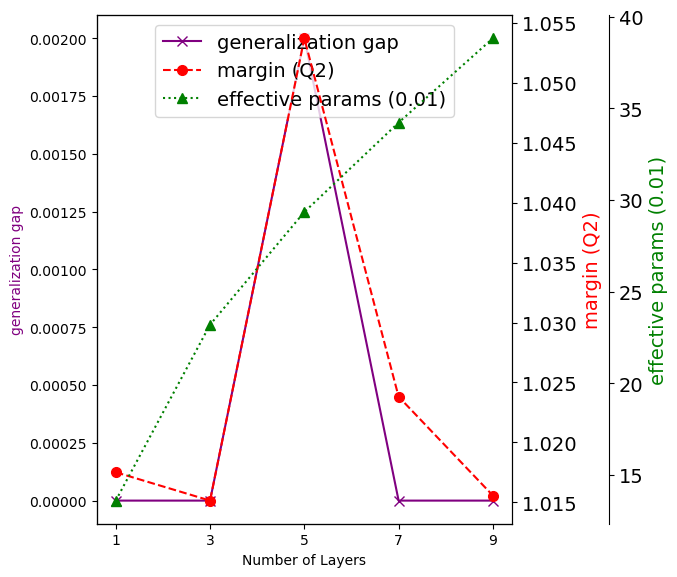

In [3]:
#getplots_average("num_layers", "generalization gap", "margin (Q1)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 1)
getplots_single("num_layers", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)

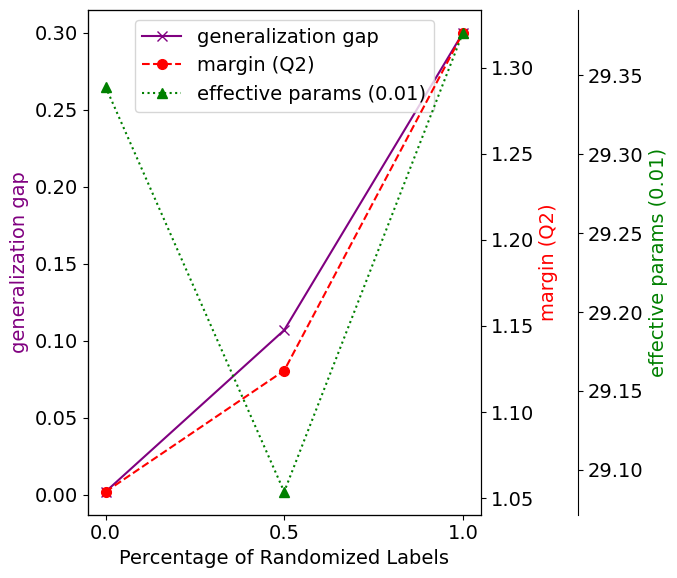

In [4]:
#getplots_average("r", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("r", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_68557/2492312479.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / x


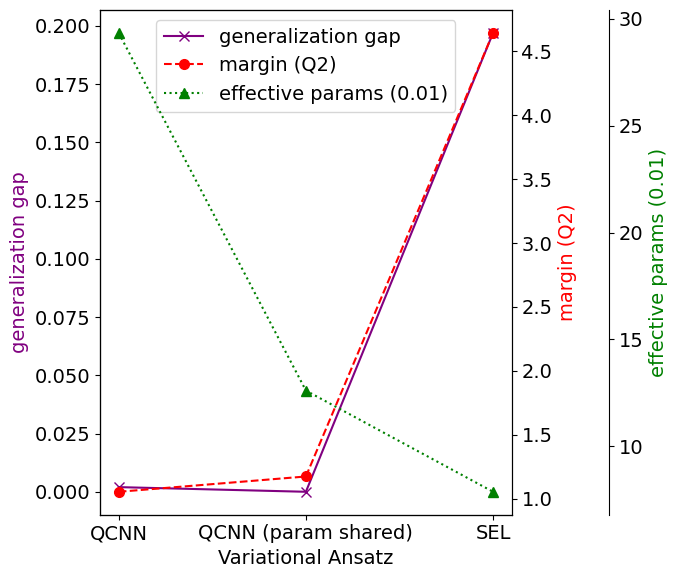

In [5]:
#getplots_average("var_ansatz", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("var_ansatz", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)